# Implementar o DCGAN no MNIST dataset

In [1]:
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from  torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.distributions import Multinomial
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import os
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

from sklearn.preprocessing import MinMaxScaler

In [2]:
dataroot = "/home/ninja/MNIST/training/"        # Root directory for dataset
workers = 12                    # Number of workers for dataloader
batch_size = 64
image_size = 32
ngpu = 1                       # Number of GPUs available. Use 0 for CPU mode.
scaler = MinMaxScaler(feature_range=(-1, 1))

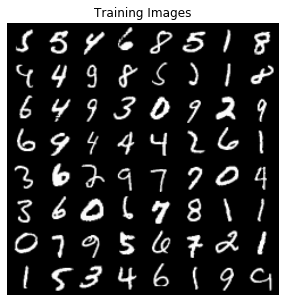

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=3),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # usar apenas se tiver mais de um canal
                           ]))
# Create the dataloader
dataloader = Data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

---
* Funções de auxílio

In [7]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(231)
    plt.plot(losses_his[0])
    plt.hlines(y=-np.log(0.5)+2.3,xmin=0,xmax=len(losses_his[4]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(232)
    plt.plot(losses_his[1])
    plt.hlines(y=-2*np.log(0.5),xmin=0,xmax=len(losses_his[3]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(233)
    plt.plot(losses_his[2])
    plt.hlines(y=2.3,xmin=0,xmax=len(losses_his[3]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Q')
    plt.subplot(234)
    plt.plot(losses_his[3])
    plt.hlines(y=0.5,xmin=0,xmax=len(losses_his[3]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(235)
    plt.plot(losses_his[4])
    plt.hlines(y=0.5,xmin=0,xmax=len(losses_his[4]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso 1')
    plt.subplot(236)
    plt.plot(losses_his[5])
    plt.hlines(y=0.5,xmin=0,xmax=len(losses_his[4]),colors='r',linestyles='dashed')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso 2')    
#     plt.subplot(337)
#     plt.plot(losses_his[6])
#     plt.grid(True)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss: Q discrete')
#     plt.subplot(338)
#     plt.plot(losses_his[7])
#     plt.grid(True)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss: Q continuous')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def plot_from_latent(c):
    c1,c2,c3,c4,c5 = c
    fake1 = get_X_from_c(label=c1, n_sample=64)
    fake2 = get_X_from_c(label=c2, n_sample=64)
    fake3 = get_X_from_c(label=c3, n_sample=64)
    fake4 = get_X_from_c(label=c4, n_sample=64)
    fake5 = get_X_from_c(label=c5, n_sample=64)
    plt.figure(figsize=(20,5))
    plt.subplot(1,5,1)
    plt.axis("off")
    plt.title(f"Fake Images: c={c1}")
    plt.imshow(np.transpose(vutils.make_grid(fake1[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,5,2)
    plt.axis("off")
    plt.title(f"Fake Images: c={c2}")
    plt.imshow(np.transpose(vutils.make_grid(fake2[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,5,3)
    plt.axis("off")
    plt.title(f"Fake Images: c={c3}")
    plt.imshow(np.transpose(vutils.make_grid(fake3[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,5,4)
    plt.axis("off")
    plt.title(f"Fake Images: c={c4}")
    plt.imshow(np.transpose(vutils.make_grid(fake4[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.subplot(1,5,5)
    plt.axis("off")
    plt.title(f"Fake Images: c={c5}")
    plt.imshow(np.transpose(vutils.make_grid(fake5[:64], padding=5, normalize=True).cpu(),(1,2,0))) 
    plt.show()
    
def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def plot_n_random_digits(x,labels=None,n_images=9,title='gan_random_digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def print_label(label):
    chosen_label = label
    batch = 1000
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, Z_dim)).cuda(),
                         y_sample_tc.type(torch.FloatTensor).cuda()).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))

def choose_c(label,batch):
    chosen_label = label
    batch = batch
    a = np.zeros(shape=[batch, 10])
    a[:,chosen_label] = 1
    return torch.Tensor(a).type(torch.FloatTensor)

def get_X_from_c(label,n_sample):
    z = noise(n_sample, nz)
    c = choose_c(label,n_sample).reshape(n_sample,nu,1,1).to(device)
    return G(z,c).detach().cpu()

def get_X_from_w(label,n_sample):
    z = noise(n_sample, nz)
    c = noise_discrete(n_sample,nu)
    w = torch.full((n_sample,), label, device=device).reshape(n_sample,1,1,1)
    return G(z,c,w).detach().cpu()

def get_X_from_c_w(label_c,label_w,n_sample):
    z = noise(n_sample, nz)
    c = choose_c(label_c,n_sample).reshape(n_sample,nu,1,1).to(device)
    w = torch.full((n_sample,), label_w, device=device).reshape(n_sample,1,1,1)
    return G(z,c,w).detach().cpu()
    
def G_reality_test(n_sample,G,D,nz,nu):
    z,c = noises(n_sample,nz,nu)
    x_out = D(G(z,c))
    D_fake = Dh(x_out)
    D_fake = D_fake.view(-1)
    print('Prob. gen data is real:  {:.6f}| +- {:.6f}'.format(D_fake.mean(),D_fake.std()))

def G_reality_test_chosen_c(n_sample,G,D,nz,nu):
    for label_c in [0,1,2,3,4,5,6,7,8,9]:
        z,_ = noises(n_sample,nz,nu)
        c = choose_c(label_c,n_sample).reshape(n_sample,nu,1,1).to(device)
        x_out = D(G(z,c))
        D_fake = Dh(x_out)
        D_fake = D_fake.view(-1)
        print(f'Label: {label_c} | Prob. gen data is real:  {D_fake.mean():.6f} +- {D_fake.std():.6f}')
    
def check_c_w_errors(n_sample,G,D,nz,nu):
    z,c,w = noises(n_sample,nz,nu)
    _, c_exp, mu_exp, var_exp = D(G(z,c,w))
    gauss = gaussian_sample(mu_exp,var_exp,n_sample)
    rmse = RMSELoss(gauss,w.reshape(n_sample,1)).item()
    acc = (torch.max(c_exp.reshape(n_sample,nu),dim=1)[1] == torch.max(c.reshape(n_sample,nu),dim=1)[1]).sum().item()/n_sample
    print('Q c accuracy  {:.2f}%'.format(acc*100))
    print('Q w mean sq   {:.2f}'.format(rmse))

def check_c_error(n_sample,G,D,nz,nu):
    z,c= noises(n_sample,nz,nu)
    x_out = D(G(z,c))
    c_exp = Q(x_out)
    acc = (torch.max(c_exp.reshape(n_sample,nu),dim=1)[1] == torch.max(c.reshape(n_sample,nu),dim=1)[1]).sum().item()/n_sample
    print('Q c accuracy  {:.2f}%'.format(acc*100))
    
def check_chosen_c_error(n_sample,G,D,nz,nu):
    for label_c in [0,1,2,3,4,5,6,7,8,9]:
        z,_ = noises(n_sample,nz,nu)
        c = choose_c(label_c,n_sample).reshape(n_sample,nu,1,1).to(device)
        x_out = D(G(z,c))
        c_exp = Q(x_out)
        acc = (torch.max(c_exp.reshape(n_sample,nu),dim=1)[1] == torch.max(c.reshape(n_sample,nu),dim=1)[1]).sum().item()/n_sample
        print(f'Label: {label_c} | Accuracy: {acc:.2%}')   
    
def noise(dim0,dim1):
    return torch.randn(dim0, dim1, 1, 1, device=device)

def noise_discrete(dim0,dim1):
    c = Multinomial(probs=torch.Tensor([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]))\
    .sample(sample_shape=torch.Size([dim0,1,1]))\
    .reshape(dim0,dim1,1,1).to(device)
    return c

def noise_uniform(dim0):
    c = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))\
    .sample(sample_shape=torch.Size([dim0,1,1])).to(device)
    return c

def noises(X_size,nz,nu):
    z = noise(X_size,nz)
    c1 = noise_discrete(X_size,nu)
#     c2 = noise_uniform(X_size)
#     c3 = noise_uniform(X_size)
    return z,c1#,c2,c3

def rescale(X):
    return (2*X)-1

def get_y_tensor(y):
    return torch.Tensor(np.eye(10)[y.cpu()-1]).type(torch.FloatTensor).to(device)\
     .reshape(batch_size,y_dim,1,1)

---

![](images/dcgan_generator.png)

In [5]:
a = torch.cat(noises(10,62,10),dim=1).cpu()
print(a.shape)
a = torch.nn.ConvTranspose2d( 72, 512, 4, 1, 0, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.Conv2d( 1, 64, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 64, 128, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 128, 256, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 256, 512, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 512, 1, 4, 1, 0, bias=False)(a)
print("D",a.shape)

torch.Size([10, 72, 1, 1])
G torch.Size([10, 512, 4, 4])
G torch.Size([10, 256, 8, 8])
G torch.Size([10, 128, 16, 16])
G torch.Size([10, 64, 32, 32])
G torch.Size([10, 1, 64, 64])
D torch.Size([10, 64, 32, 32])
D torch.Size([10, 128, 16, 16])
D torch.Size([10, 256, 8, 8])
D torch.Size([10, 512, 4, 4])
D torch.Size([10, 1, 1, 1])


In [44]:
a = torch.cat(noises(10,62,10),dim=1).cpu()
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 72, 1024, 4, 1, 0, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 1024, 128, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.Conv2d( 3, 64, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 64, 128, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 128, 256, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 256, 1, 4, 1, 0, bias=False)(a)
print("D",a.shape)

G torch.Size([10, 72, 1, 1])
G torch.Size([10, 1024, 4, 4])
G torch.Size([10, 128, 8, 8])
G torch.Size([10, 64, 16, 16])
G torch.Size([10, 3, 32, 32])
D torch.Size([10, 64, 16, 16])
D torch.Size([10, 128, 8, 8])
D torch.Size([10, 256, 4, 4])
D torch.Size([10, 1, 1, 1])


In [70]:
a = torch.cat(noises(10,62,10),dim=1).cpu()
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 72, 1024, 4, 1, 0, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 1024, 128, 7, 1, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)(a)
print("G",a.shape)
a = torch.nn.Conv2d( 3, 64, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 64, 128, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 128, 1024, 4, 2, 1, bias=False)(a)
print("D",a.shape)
a = torch.nn.Conv2d( 1024, 1, 4, 1, 0, bias=False)(a)
print("D",a.shape)

G torch.Size([10, 72, 1, 1])
G torch.Size([10, 1024, 4, 4])
G torch.Size([10, 128, 8, 8])
G torch.Size([10, 64, 16, 16])
G torch.Size([10, 3, 32, 32])
D torch.Size([10, 64, 16, 16])
D torch.Size([10, 128, 8, 8])
D torch.Size([10, 1024, 4, 4])
D torch.Size([10, 1, 1, 1])


In [82]:
z,c = noises(10,62,10)
Dh(D(G(z,c))).shape
Q(D(G(z,c))).shape

torch.Size([10, 10])

In [83]:
Dh(D(X_real)).shape
Q(D(X_real)).shape

torch.Size([32, 10])

In [99]:
256*4*4

4096

In [118]:
nc, nw, nu, nz, ngf, ndf = [1,2,10,62,64,64]
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet, self).__init__()
        self.ngpu = ngpu
        self.conv1 = torch.nn.ConvTranspose2d( 72, 1024, 4, 1, 0, bias=False)
#         self.conv2 = torch.nn.BatchNorm2d(512)
#         self.conv3 = torch.nn.ConvTranspose2d( 512, 256, 3, 1, 1, bias=False)
        self.conv4 = torch.nn.BatchNorm2d(1024)
        self.conv5  = torch.nn.ConvTranspose2d( 1024, 128, 7, 1, 1, bias=False)
        self.conv6  = torch.nn.BatchNorm2d(128)
        self.conv7  = torch.nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False)
        self.conv8  = torch.nn.BatchNorm2d(64)
        self.conv9  = torch.nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)

    def forward(self, z,c):
        h = self.conv1(torch.cat((z,c),dim=1))
#         h = F.relu(self.conv2(h))
#         h = self.conv3(h)
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = F.relu(self.conv6(h))
        h = self.conv7(h)
        h = F.relu(self.conv8(h))
        h = torch.tanh(self.conv9(h))
        return h

class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet, self).__init__()
        self.ngpu = ngpu
        self.conv1 = torch.nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = torch.nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv4 = torch.nn.BatchNorm2d(128)
        self.conv5 = torch.nn.LeakyReLU(0.2, inplace=True)
        self.conv6 = torch.nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv7 = torch.nn.BatchNorm2d(256)
        self.conv8 = torch.nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x_out = self.conv1(x)
        x_out = self.conv2(x_out)
        x_out = self.conv3(x_out)
        x_out = self.conv4(x_out)
        x_out = self.conv5(x_out)
        x_out = self.conv6(x_out)
        x_out = self.conv7(x_out)
        x_out = self.conv8(x_out)
#         p_x_out = torch.sigmoid(self.conv9(x_out))
        return x_out        
    
class Dhead(torch.nn.Module):
    def __init__(self, ngpu):
        super(Dhead, self).__init__()
        self.ngpu = ngpu
#         self.conv9 = torch.nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        self.flat = nn.modules.Flatten()
        self.linear1 = torch.nn.Linear(4096, 1)

    def forward(self, x_out):
        h = self.flat(x_out)
        h = self.linear1(h)
        h = torch.sigmoid(h)
        return h

class Qhead(torch.nn.Module):
    def __init__(self, ngpu):
        super(Qhead, self).__init__()
        self.ngpu = ngpu
        self.conv9 = torch.nn.Conv2d(256, 128, 4, 1, 0, bias=False)
        self.conv10 = torch.nn.BatchNorm2d(128)
        self.conv11 = torch.nn.LeakyReLU(0.2, inplace=True)
        self.flat = nn.modules.Flatten()
        self.linear1 = torch.nn.Linear(128, 10)
#         self.linear2 = torch.nn.Linear(100, 10)
        
    def forward(self, d_out):
#         c = self.flat(d_out)
        c = self.conv9(d_out)
        c = self.conv10(c)
        c = self.conv11(c)
        c = self.flat(c)
        c = torch.softmax(self.linear1(c), dim=1)
        return c

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G = GNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
G.apply(weights_init)
D = DNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
D.apply(weights_init)
Dh = Dhead(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Dh = nn.DataParallel(Dh, list(range(ngpu)))
Dh.apply(weights_init)
Q = Qhead(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Q = nn.DataParallel(Q, list(range(ngpu)))
Q.apply(weights_init)

lrd,lrg = [2e-4,1e-3]
beta = 0.5
# Definimos os otimizadores
G_optim  = optim.Adam(G.parameters(),  lr=lrg, betas=(beta,0.999))
D_optim  = optim.Adam([{'params':Dh.parameters()}, {'params':D.parameters()}],  lr=lrd, betas=(beta,0.999))
Q_optim  = optim.Adam(Q.parameters(),  lr=lrg, betas=(beta,0.999))


def Q_loss_func(c_expected, c):
    return torch.mean(-torch.sum(c * torch.log(c_expected + 1e-8), dim=1)) + 2.3

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

loss = torch.nn.BCELoss()
loss_logits = nn.BCEWithLogitsLoss()
l2_loss = torch.nn.MSELoss()

def RMSELoss(x_fake,x_real):
    return torch.sqrt(torch.mean((x_fake-x_real)**2))

def gaussian_sample(mu_expected,var_expected, dim):
    return Normal(mu_expected.reshape(dim,1),var_expected.reshape(dim,1)).sample()

real_label = 1
fake_label = 0

fixed_z,fixed_c = noises(X_size=64,nz=nz,nu=nu)

G_his, D_his, D_real_his, D_fake1_his, D_fake2_his, Q_dis_his, Q_con_his, Q_his = [[],[],[],[],[],[],[],[]]
losses_his = [G_his,D_his,Q_his,D_real_his,D_fake1_his, D_fake2_his, Q_dis_his, Q_con_his]
img_list = []

def reset_grad():
    G_optim.zero_grad()
    Q_optim.zero_grad()
    D_optim.zero_grad()

In [49]:
#load saved networks
# G.load_state_dict(torch.load('models/g_infocgan_mnist.pt'))
# D.load_state_dict(torch.load('models/d_infocgan_mnist.pt'))
# Q.load_state_dict(torch.load('models/q_infocgan_mnist.pt'))

In [121]:
%%time
iters = 0
num_epochs = 2

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
#         X_real = rescale(data[0].to(device))
        D_optim.zero_grad()
        X_real = data[0].to(device)
        X_size = X_real.size(0)
        ones = torch.full((X_size,), real_label, device=device)
        zeros = torch.full((X_size,), fake_label, device=device)
        
        # train D with real data
        x_out = D(X_real)
        X_real_out = Dh(x_out)
        X_real_out  = X_real_out.view(-1)
        D_loss_real = loss(X_real_out, ones)
        D_loss_real.backward()
        D_loss_real_mean = X_real_out.mean().item()

        # train D with fake data
        z,c = noises(X_size,nz,nu)
        X_fake = G(z,c)
        x_out = D(X_fake.detach())
        X_fake_out = Dh(x_out)
        X_fake_out = X_fake_out.view(-1)

        D_loss_fake = loss(X_fake_out, zeros)
        D_loss_fake.backward()
        D_loss_fake_mean_1 = X_fake_out.mean().item()
        D_loss = D_loss_real + D_loss_fake
        D_optim.step()

        # update G
        Q_optim.zero_grad()
        G_optim.zero_grad()
        x_out = D(X_fake)
        X_fake_out = Dh(x_out)
        X_fake_out = X_fake_out.view(-1)
        c_exp = Q(x_out)
        Q_loss = Q_loss_func(c_exp.reshape(X_size,nu),c.reshape(X_size,nu))
        Gan_loss = loss(X_fake_out, ones)
#         Gan_loss.backward()
#         Q_loss.backward()
        G_loss = Gan_loss + 1.0*Q_loss
        G_loss.backward()
        D_loss_fake_mean_2 = X_fake_out.mean().item()
        Q_optim.step()
        G_optim.step()
#         reset_grad()
        

        if i == int(60000/batch_size):
            print(f'Epoch-{epoch+1} | Av. D_loss:  {D_loss.item():.3f} | Av. G_loss: {G_loss.item():.3f}')
            print(f'prob_real:  {D_loss_real_mean:.3f} | prob_fake_1:    {D_loss_fake_mean_1:.3f} | prob_fake_2: {D_loss_fake_mean_2:.3f}')
            print(f'Q loss: {Q_loss.item():.3f}')
#             print('Q loss:  {:.3f} | Q loss disc: {:.3f} | Q loss cont: {:.3f}'.format(
#                 Q_loss.item(),Q_loss_discrete.item(),Q_loss_continuous.item()))
            G_reality_test(2000,G,D,nz,nu)
            check_c_error(2000,G,D,nz,nu)
#             plot_losses(losses_his)
#             plot_from_latent(c=[0,1,2,3,4])
#             plot_from_latent(c=[5,6,7,8,9])
            print('-'*80)

        G_his.append(G_loss.item())
        D_his.append(D_loss.item())
        D_real_his.append(D_loss_real_mean)
        D_fake1_his.append(D_loss_fake_mean_1)
        D_fake2_his.append(D_loss_fake_mean_2)
#         Q_dis_his.append(Q_loss_discrete.item())
#         Q_con_his.append(Q_loss_continuous.item())
        Q_his.append(Q_loss.item())
        
        if (iters % int(60000/batch_size)==0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_z,fixed_c).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Epoch-1 | Av. D_loss:  2.679 | Av. G_loss: 4.477
prob_real:  0.983 | prob_fake_1:    0.924 | prob_fake_2: 0.125
Q loss: 2.319
Prob. gen data is real:  0.200076| +- 0.078976
Q c accuracy  98.70%
--------------------------------------------------------------------------------
Epoch-2 | Av. D_loss:  1.391 | Av. G_loss: 5.442
prob_real:  0.950 | prob_fake_1:    0.715 | prob_fake_2: 0.049
Q loss: 2.303
Prob. gen data is real:  0.112120| +- 0.063602
Q c accuracy  99.75%
--------------------------------------------------------------------------------
CPU times: user 1min 26s, sys: 1.33 s, total: 1min 28s
Wall time: 1min 26s


Reality per label
Prob. gen data is real:  0.116331| +- 0.066963
Label: 0 | Prob. gen data is real:  0.084983 +- 0.038393
Label: 1 | Prob. gen data is real:  0.088396 +- 0.059466
Label: 2 | Prob. gen data is real:  0.112562 +- 0.053767
Label: 3 | Prob. gen data is real:  0.055593 +- 0.041626
Label: 4 | Prob. gen data is real:  0.087559 +- 0.043746
Label: 5 | Prob. gen data is real:  0.085156 +- 0.047304
Label: 6 | Prob. gen data is real:  0.158697 +- 0.067577
Label: 7 | Prob. gen data is real:  0.108351 +- 0.070176
Label: 8 | Prob. gen data is real:  0.114109 +- 0.056880
Label: 9 | Prob. gen data is real:  0.144624 +- 0.066872
Accuracy per label
Q c accuracy  99.70%
Label: 0 | Accuracy: 14.00%
Label: 1 | Accuracy: 13.95%
Label: 2 | Accuracy: 12.30%
Label: 3 | Accuracy: 12.60%
Label: 4 | Accuracy: 14.90%
Label: 5 | Accuracy: 9.40%
Label: 6 | Accuracy: 15.50%
Label: 7 | Accuracy: 16.20%
Label: 8 | Accuracy: 13.15%
Label: 9 | Accuracy: 11.70%


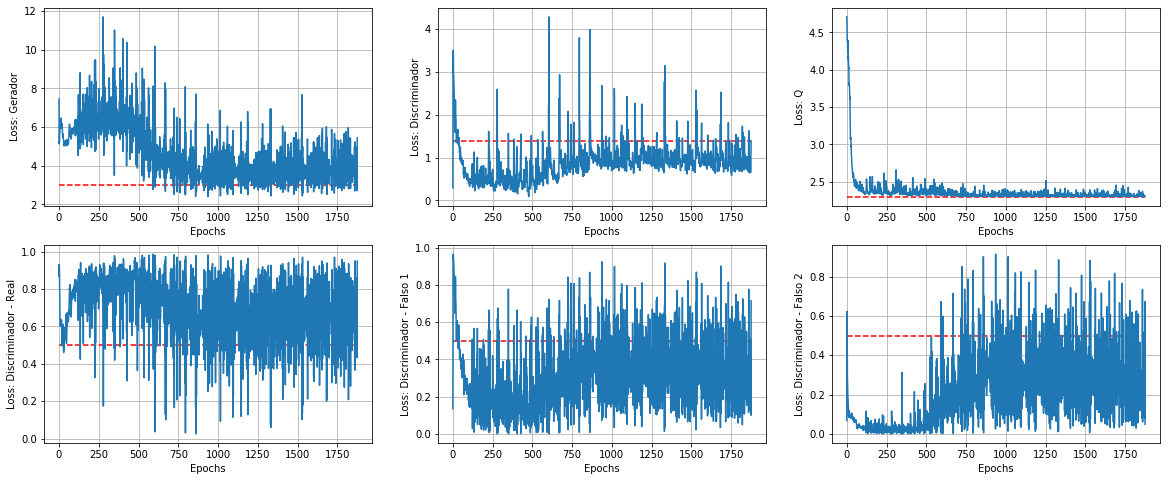

In [122]:
print("Reality per label")
G_reality_test(2000,G,D,nz,nu)
G_reality_test_chosen_c(2000,G,D,nz,nu)
print("Accuracy per label")
check_c_error(2000,G,D,nz,nu)
check_chosen_c_error(2000,G,D,nz,nu)
plot_losses(losses_his)

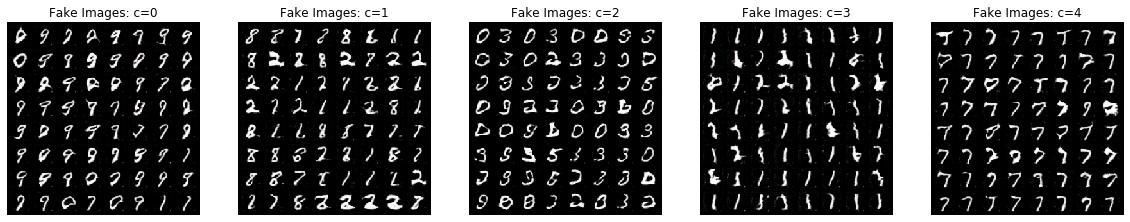

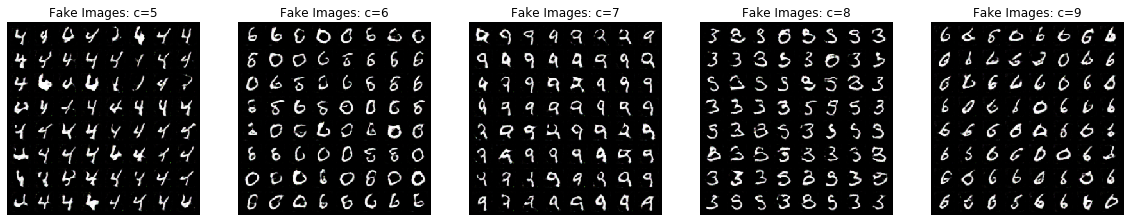

In [123]:
plot_from_latent(c=[0,1,2,3,4])
plot_from_latent(c=[5,6,7,8,9])

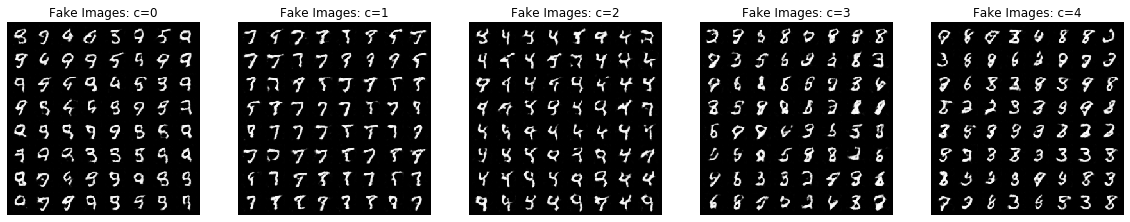

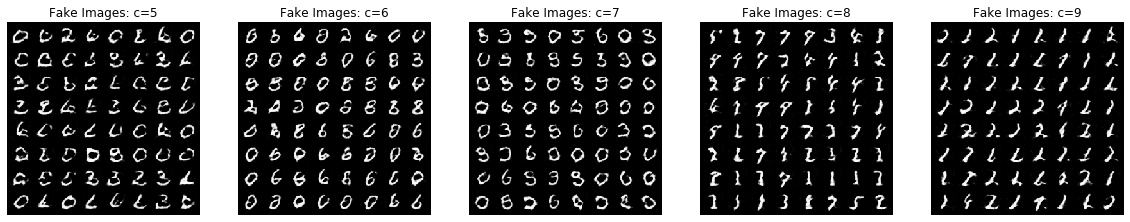

In [27]:
plot_from_latent(c=[0,1,2,3,4])
plot_from_latent(c=[5,6,7,8,9])

In [171]:
# #save networks
# torch.save(G.state_dict(), 'models/g_infodcgan_mnist_original_20k.pt')
# torch.save(D.state_dict(), 'models/d_infodcgan_mnist_original_20k.pt')

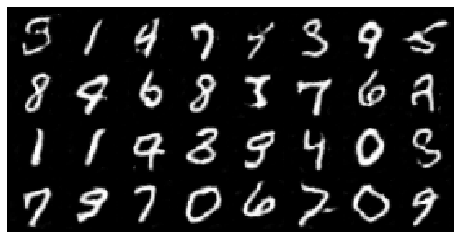

In [172]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

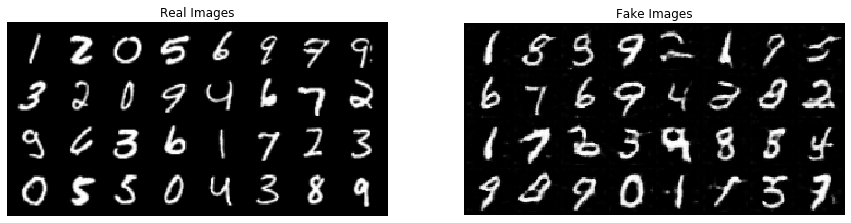

In [139]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()